
# ABCDisCo Single-DisCo Tutorial (Torch + optional PennyLane backend)

This notebook reproduces the **Single-DisCo** workflow described in [T. Aarrestad *et al.*, *Eur. Phys. J. C* **81**, 1003 (2021), arXiv:2007.14400](https://arxiv.org/abs/2007.14400). It mirrors the reference scripts shipped with this repository so you can validate the mass-decorrelated baseline before moving to the Double-DisCo configuration.

> **Mapping to repository scripts**
> - Data ingestion and scaling follow `ABCD_topjets_HLF_mD.py` (lines 69-101) together with the dataset helpers in `data_loader.py` (lines 1-63).
> - The neural-network head reuses `networks.DNNclassifier` (lines 8-44), while the DisCo penalty mirrors `model.py` (lines 24-86) plus `disco.py` (lines 14-118).
> - Evaluation adapts the single-score diagnostics from `evaluation.py` (lines 1-70), including the Jensen-Shannon divergence vs. background rejection scan.

The workflow is organised as:

1. **Setup & configuration** (Single-DisCo hyperparameters).
2. **Data loading and preprocessing** (min-max scaling, feature selection matching `ABCD_topjets_HLF_mD.py`).
3. **Model definition** with interchangeable Torch/PennyLane heads.
4. **Training** with the DisCo mass decorrelation penalty.
5. **Diagnostics & evaluation**: ROC curves, distance correlations, JSD vs. background rejection, and mass sculpting checks.
6. **Export** of trained weights and inference scores.

> **Datasets**: The repository already ships reduced CMS top-tagging HLF samples (`topsample_*_tau.dat.gz`). You can run this notebook end-to-end without external downloads.



## Environment preparation

Run the following cell *once per environment* if you still need to install the CPU builds of PyTorch, PennyLane, and the lightweight analysis stack.


In [1]:

# Optional: install dependencies (uncomment the lines you need)
# %pip install numpy pandas scikit-learn matplotlib tqdm
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# %pip install pennylane pennylane-lightning
# %pip install pyhf



## 0. Configuration (mirrors `ABCD_topjets_HLF_mD.py` lines 69-126)

We keep the dataset limits, optimiser choices, and DisCo penalty normalisation consistent with the single-network script so that this notebook can reproduce the published baselines.


In [2]:

from __future__ import annotations

import gzip
from pathlib import Path
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.metrics import auc, roc_curve
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

# Repository-local modules (mirror original scripts)
import sys
project_root = str(Path.cwd().resolve().parent)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from disco import distance_corr_unbiased
from networks import DNNclassifier

try:
    import pennylane as qml  # optional backend
    PENNYLANE_AVAILABLE = True
except ImportError:  # keep optional
    PENNYLANE_AVAILABLE = False

plt.style.use("seaborn-v0_8-talk")

SEED = 1337
rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)

# Use project root (one level up from this notebook) for data files
DATA_ROOT = Path.cwd().resolve().parent
RAW_FILES = {
    "train": DATA_ROOT / "topsample_train_tau.dat.gz",
    "val": DATA_ROOT / "topsample_val_tau.dat.gz",
    "test": DATA_ROOT / "topsample_test_tau.dat.gz",
}

# Toggle to match the full training statistics used in the paper.
FULL_DATASET = False
EVENT_LIMITS = {
    "train": 10000 if not FULL_DATASET else None,
    "val": 5000 if not FULL_DATASET else None,
    "test": 5000 if not FULL_DATASET else None,
}

BATCH_SIZE = 512
EPOCHS = 50 if not FULL_DATASET else 200
LEARNING_RATE = 1e-3

# DisCo regularisation weight (cf. model.py lines 24-86)
LAMBDA_MASS = 200.0  # strength of the distance-correlation penalty between score and jet mass

# QML backend knobs (used only when BACKEND == "qml")
BACKEND = "torch"  # switch to "qml" after installing PennyLane
N_QUBITS = 6
QML_LAYERS = 2
QML_DEVICE = "default.qubit"

ORIGINAL_FEATURES = [
    "mass",
    "pt",
    "tau1_half",
    "tau2_half",
    "tau3_half",
    "tau1",
    "tau2",
    "tau3",
    "tau4",
    "tau1_sq",
    "tau2_sq",
    "tau3_sq",
    "tau4_sq",
]

# The single-network setup removes the first two observables (mass, pT) from the classifier input
SINGLE_FEATURE_INDICES = list(range(2, len(ORIGINAL_FEATURES)))
FEATURE_NAMES = [ORIGINAL_FEATURES[i] for i in SINGLE_FEATURE_INDICES]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


/global/common/software/m4138/ABCDisCo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda



## 1. Data loading & scaling (`ABCD_topjets_HLF_mD.py` lines 69-95)

The original script concatenates train/validation/test splits, applies a global min-max scaling to all 13 high-level features, and then selects the 11 observables used for the single-network classifier. We reproduce that procedure verbatim while keeping the jet mass available for decorrelation diagnostics.


In [3]:

def _load_tau_file(path: Path) -> np.ndarray:
    if not path.exists():
        raise FileNotFoundError(f"Missing dataset: {path}")
    with gzip.open(path, "rt") as handle:
        array = np.loadtxt(handle, delimiter=",", skiprows=15)
    if array.ndim != 2 or array.shape[1] != 14:
        raise ValueError(f"Unexpected shape {array.shape} in {path}")
    return array


def load_and_scale(raw_files: Dict[str, Path]) -> Tuple[Dict[str, np.ndarray], Dict[str, np.ndarray], Dict[str, np.ndarray]]:
    """Replicate the min-max scaling used in `ABCD_topjets_HLF_mD.py`."""
    raw_arrays = {split: _load_tau_file(path) for split, path in raw_files.items()}

    concatenated = np.vstack([arr[:, 1:] for arr in raw_arrays.values()])
    feat_min = concatenated.min(axis=0)
    feat_range = np.maximum(concatenated.max(axis=0) - feat_min, 1e-8)

    features: Dict[str, np.ndarray] = {}
    labels: Dict[str, np.ndarray] = {}
    masses: Dict[str, np.ndarray] = {}

    for split, array in raw_arrays.items():
        scaled = (array[:, 1:] - feat_min) / feat_range
        features[split] = scaled.astype(np.float32)
        labels[split] = array[:, 0].astype(np.float32)
        masses[split] = array[:, 1].astype(np.float32)

    return features, labels, masses


features_all, labels, masses = load_and_scale(RAW_FILES)
features = {split: feats[:, SINGLE_FEATURE_INDICES] for split, feats in features_all.items()}

summary = []
for split in ("train", "val", "test"):
    limit = EVENT_LIMITS[split]
    n_events = features[split].shape[0] if limit is None else min(limit, features[split].shape[0])
    summary.append({
        "split": split,
        "events": n_events,
        "signal_fraction": float(labels[split][:n_events].mean()),
    })

summary_df = pd.DataFrame(summary)
display(summary_df)

pd.DataFrame(features["train"][:5], columns=FEATURE_NAMES)


,split,events,signal_fraction
0,train,10000,0.4990
1,val,5000,0.4978
2,test,5000,0.4980


,tau1_half,tau2_half,tau3_half,tau1,tau2,tau3,tau4,tau1_sq,tau2_sq,tau3_sq,tau4_sq
0,0.536776,0.500864,0.574945,0.394624,0.339701,0.385666,0.344517,0.234931,0.193813,0.169328,0.218196
1,0.435426,0.372848,0.350198,0.341338,0.251511,0.206516,0.182207,0.238264,0.154509,0.071783,0.109701
2,0.258615,0.200300,0.194578,0.202230,0.131560,0.094665,0.105227,0.161852,0.109971,0.035088,0.054957
3,0.553174,0.588799,0.544666,0.396228,0.439678,0.412337,0.349588,0.231673,0.247405,0.198532,0.148587
4,0.270467,0.262601,0.248148,0.154974,0.114489,0.119845,0.133753,0.109002,0.039658,0.053723,0.077720



## 2. Torch datasets (`data_loader.py` lines 22-63)

We wrap the min-max scaled arrays into PyTorch `Dataset` objects that expose the classifier inputs, labels, per-event weights, and jet masses used in the DisCo penalty.


In [4]:

class TorchTopTaggingDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray, mass: np.ndarray, weight: np.ndarray | None = None):
        self.x = torch.as_tensor(x, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.float32)
        if weight is None:
            weight = np.ones_like(y, dtype=np.float32)
        self.w = torch.as_tensor(weight, dtype=torch.float32)
        self.mass = torch.as_tensor(mass, dtype=torch.float32)

    def __len__(self) -> int:
        return self.x.shape[0]

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx], self.w[idx], self.mass[idx]


def _clip_events(split: str, array: np.ndarray) -> np.ndarray:
    limit = EVENT_LIMITS[split]
    if limit is None:
        return array
    return array[:limit]


train_set = TorchTopTaggingDataset(
    _clip_events("train", features["train"]),
    _clip_events("train", labels["train"]),
    _clip_events("train", masses["train"]),
)
val_set = TorchTopTaggingDataset(
    _clip_events("val", features["val"]),
    _clip_events("val", labels["val"]),
    _clip_events("val", masses["val"]),
)
test_set = TorchTopTaggingDataset(
    _clip_events("test", features["test"]),
    _clip_events("test", labels["test"]),
    _clip_events("test", masses["test"]),
)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

len(train_set), len(val_set), len(test_set)


(10000, 5000, 5000)


## 3. Model backends (`networks.py` lines 8-44)

The Single-DisCo setup uses a single `DNNclassifier` head. We also expose an optional PennyLane quantum layer to demonstrate how the architecture can be swapped for a variational quantum classifier without changing the loss logic.


In [5]:

class TorchSingleDisco(nn.Module):
    """Wrap one `DNNclassifier` head exactly as in the Single-DisCo script."""

    def __init__(self, n_features: int):
        super().__init__()
        self.head = DNNclassifier(n_features, 2)

    def forward(self, x: torch.Tensor):
        logits = self.head(x)
        score = F.softmax(logits, dim=1)[:, 1]
        return logits, score


class PennyLaneSingleDisco(nn.Module):
    """Minimal PennyLane VQC head compatible with the Single-DisCo loss."""

    def __init__(self, n_features: int, n_qubits: int = 6, layers: int = 2, device_name: str = "default.qubit"):
        if not PENNYLANE_AVAILABLE:
            raise RuntimeError("PennyLane is not installed. Run `%pip install pennylane pennylane-lightning`.")
        super().__init__()
        self.n_qubits = n_qubits
        self.n_features = n_features

        qdevice = qml.device(device_name, wires=n_qubits)
        weight_shapes = {"weights": (layers, n_qubits)}

        @qml.qnode(qdevice, interface="torch")
        def circuit(inputs, weights):
            x_pad = torch.zeros(n_qubits, dtype=inputs.dtype, device=inputs.device)
            take = min(inputs.shape[-1], n_qubits)
            x_pad[:take] = inputs[..., :take]
            qml.templates.AngleEmbedding(x_pad, wires=range(n_qubits), rotation="Y")
            qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(2)]

        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
        self.head = nn.Linear(2, 2)

    def forward(self, x: torch.Tensor):
        q_inputs = x[:, : self.n_qubits]
        q_features = self.qlayer(q_inputs)
        logits = self.head(q_features)
        score = F.softmax(logits, dim=1)[:, 1]
        return logits, score


def build_model(n_features: int) -> nn.Module:
    if BACKEND == "qml":
        model = PennyLaneSingleDisco(n_features, n_qubits=N_QUBITS, layers=QML_LAYERS, device_name=QML_DEVICE)
    else:
        model = TorchSingleDisco(n_features)
    return model.to(DEVICE)


model = build_model(len(FEATURE_NAMES))
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model


/global/u2/s/sungwon/QML_project/ABCDisCo/networks.py:26: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  init.kaiming_normal(self.classifier.weight)


TorchSingleDisco(
  (head): DNNclassifier(
    (dense_1): Linear(in_features=11, out_features=64, bias=True)
    (bn2): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn64): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense_2): Linear(in_features=64, out_features=64, bias=True)
    (dense_3): Linear(in_features=64, out_features=64, bias=True)
    (classifier): Linear(in_features=64, out_features=2, bias=True)
  )
)


## 4. Loss function with DisCo penalty (`model.py` lines 24-86 & `disco.py`)

We compute the weighted binary cross-entropy loss and add the unbiased distance-correlation penalty between the classifier score and jet mass on background events, following the original `train_model(..., decorr_mode='dist_unbiased')` implementation.


In [6]:

def distance_corr_safe(x: torch.Tensor, y: torch.Tensor, weight: torch.Tensor) -> torch.Tensor:
    if x.numel() <= 2 or y.numel() <= 2:
        return torch.zeros(1, device=x.device, dtype=x.dtype)
    normed = weight / (weight.sum() + 1e-12) * len(weight)
    return distance_corr_unbiased(x, y, normed, power=1)


def compute_losses(model: nn.Module, batch: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, Dict[str, float]]:
    features, labels, weights, masses = batch
    features = features.to(DEVICE)
    labels = labels.to(DEVICE)
    weights = weights.to(DEVICE)
    masses = masses.to(DEVICE)

    logits, score = model(features)
    loss_cls = F.binary_cross_entropy(score, labels, weight=weights)
    loss = loss_cls

    metrics = {
        "loss_cls": float(loss_cls.detach().cpu()),
    }

    background = labels < 0.5
    if background.any() and LAMBDA_MASS > 0.0:
        w_bkg = torch.ones_like(weights[background])
        d_mass = distance_corr_safe(score[background], masses[background], w_bkg)
        loss = loss + LAMBDA_MASS * d_mass
        metrics["dCorr_s_m"] = float(d_mass.detach().cpu())

    return loss, metrics



## 5. Training loop (`model.py` lines 88-170)

We adapt the original `train`/`val` helpers to work seamlessly on CPU/GPU and to log the DisCo decorrelation term alongside the classification loss.


In [7]:

def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer) -> Dict[str, float]:
    model.train()
    agg: Dict[str, list[float]] = {}
    for batch in tqdm(loader, leave=False, desc="train"):
        optimizer.zero_grad(set_to_none=True)
        loss, metrics = compute_losses(model, batch)
        loss.backward()
        optimizer.step()
        for key, value in metrics.items():
            agg.setdefault(key, []).append(value)
    return {key: float(np.mean(values)) for key, values in agg.items()}


def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, Dict[str, float]]:
    model.eval()
    scores, labels_all, weights_all, masses_all = [], [], [], []
    agg: Dict[str, list[float]] = {}
    with torch.no_grad():
        for batch in tqdm(loader, leave=False, desc="eval"):
            loss, metrics = compute_losses(model, batch)
            features, labels, weights, masses = batch
            features = features.to(DEVICE)
            _, score = model(features)
            scores.append(score.cpu().numpy())
            labels_all.append(labels.numpy())
            weights_all.append(weights.numpy())
            masses_all.append(masses.numpy())
            agg.setdefault("loss", []).append(float(loss.detach().cpu()))
            for key, value in metrics.items():
                agg.setdefault(key, []).append(value)
    scores = np.concatenate(scores)
    labels_all = np.concatenate(labels_all)
    weights_all = np.concatenate(weights_all)
    masses_all = np.concatenate(masses_all)
    metrics_mean = {key: float(np.mean(values)) for key, values in agg.items()}
    return scores, labels_all, weights_all, masses_all, metrics_mean


history = []
for epoch in range(EPOCHS):
    train_metrics = train_one_epoch(model, train_loader, optimizer)
    s_val, y_val, w_val, m_val, val_metrics = evaluate(model, val_loader)
    fpr, tpr, _ = roc_curve(y_val, s_val, sample_weight=w_val)
    roc_auc = auc(fpr, tpr)
    record = {
        "epoch": epoch,
        "roc_auc": roc_auc,
        **{f"train_{k}": v for k, v in train_metrics.items()},
        **{f"val_{k}": v for k, v in val_metrics.items()},
    }
    history.append(record)
    print(
        f"Epoch {epoch:03d} | AUC={roc_auc:.3f} | "
        f"train_loss={train_metrics['loss_cls']:.3f} | val_loss={val_metrics['loss_cls']:.3f}"
    )

history_df = pd.DataFrame(history)
history_df.tail()


Epoch 000 | AUC=0.356 | train_loss=0.711 | val_loss=0.698


Epoch 001 | AUC=0.307 | train_loss=0.727 | val_loss=0.712


Epoch 002 | AUC=0.365 | train_loss=0.732 | val_loss=0.723


Epoch 003 | AUC=0.399 | train_loss=0.725 | val_loss=0.736


Epoch 004 | AUC=0.490 | train_loss=0.727 | val_loss=0.718


Epoch 005 | AUC=0.496 | train_loss=0.724 | val_loss=0.719


Epoch 006 | AUC=0.504 | train_loss=0.728 | val_loss=0.717


Epoch 007 | AUC=0.436 | train_loss=0.734 | val_loss=0.749


Epoch 008 | AUC=0.424 | train_loss=0.749 | val_loss=0.763


Epoch 009 | AUC=0.446 | train_loss=0.756 | val_loss=0.755


Epoch 010 | AUC=0.488 | train_loss=0.750 | val_loss=0.733


Epoch 011 | AUC=0.510 | train_loss=0.746 | val_loss=0.722


Epoch 012 | AUC=0.473 | train_loss=0.743 | val_loss=0.742


Epoch 013 | AUC=0.457 | train_loss=0.745 | val_loss=0.750


Epoch 014 | AUC=0.497 | train_loss=0.735 | val_loss=0.730


Epoch 015 | AUC=0.511 | train_loss=0.725 | val_loss=0.722


Epoch 016 | AUC=0.542 | train_loss=0.718 | val_loss=0.708


Epoch 017 | AUC=0.564 | train_loss=0.713 | val_loss=0.696


Epoch 018 | AUC=0.533 | train_loss=0.705 | val_loss=0.713


Epoch 019 | AUC=0.536 | train_loss=0.707 | val_loss=0.710


Epoch 020 | AUC=0.600 | train_loss=0.707 | val_loss=0.678


Epoch 021 | AUC=0.562 | train_loss=0.702 | val_loss=0.697


Epoch 022 | AUC=0.536 | train_loss=0.708 | val_loss=0.711


Epoch 023 | AUC=0.569 | train_loss=0.709 | val_loss=0.694


Epoch 024 | AUC=0.529 | train_loss=0.705 | val_loss=0.715


Epoch 025 | AUC=0.575 | train_loss=0.705 | val_loss=0.691


Epoch 026 | AUC=0.621 | train_loss=0.702 | val_loss=0.669


Epoch 027 | AUC=0.550 | train_loss=0.690 | val_loss=0.708


Epoch 028 | AUC=0.585 | train_loss=0.700 | val_loss=0.690


Epoch 029 | AUC=0.584 | train_loss=0.688 | val_loss=0.689


Epoch 030 | AUC=0.587 | train_loss=0.690 | val_loss=0.686


Epoch 031 | AUC=0.606 | train_loss=0.691 | val_loss=0.678


Epoch 032 | AUC=0.595 | train_loss=0.696 | val_loss=0.683


Epoch 033 | AUC=0.593 | train_loss=0.692 | val_loss=0.684


Epoch 034 | AUC=0.616 | train_loss=0.690 | val_loss=0.668


Epoch 035 | AUC=0.660 | train_loss=0.667 | val_loss=0.644


Epoch 036 | AUC=0.634 | train_loss=0.687 | val_loss=0.665


Epoch 037 | AUC=0.603 | train_loss=0.679 | val_loss=0.681


Epoch 038 | AUC=0.626 | train_loss=0.667 | val_loss=0.673


Epoch 039 | AUC=0.625 | train_loss=0.672 | val_loss=0.669


Epoch 040 | AUC=0.650 | train_loss=0.666 | val_loss=0.655


Epoch 041 | AUC=0.667 | train_loss=0.655 | val_loss=0.645


Epoch 042 | AUC=0.659 | train_loss=0.653 | val_loss=0.654


Epoch 043 | AUC=0.621 | train_loss=0.653 | val_loss=0.677


Epoch 044 | AUC=0.642 | train_loss=0.661 | val_loss=0.660


Epoch 045 | AUC=0.703 | train_loss=0.658 | val_loss=0.624


Epoch 046 | AUC=0.650 | train_loss=0.644 | val_loss=0.659


Epoch 047 | AUC=0.613 | train_loss=0.659 | val_loss=0.682


Epoch 048 | AUC=0.631 | train_loss=0.672 | val_loss=0.668


Epoch 049 | AUC=0.639 | train_loss=0.671 | val_loss=0.665


,epoch,roc_auc,train_loss_cls,train_dCorr_s_m,val_loss,val_loss_cls,val_dCorr_s_m
45,45,0.702522,0.658480,-0.001016,1.951284,0.623810,0.006637
46,46,0.650375,0.644285,0.000070,1.232968,0.659214,0.002869
47,47,0.612805,0.658920,-0.002247,2.382727,0.682334,0.008502
48,48,0.630571,0.672048,0.002171,1.130045,0.668490,0.002308
49,49,0.638704,0.670728,0.000713,0.705977,0.665335,0.000203



### Training diagnostics

We track the classification loss and the distance-correlation penalty to verify convergence and decorrelation strength.


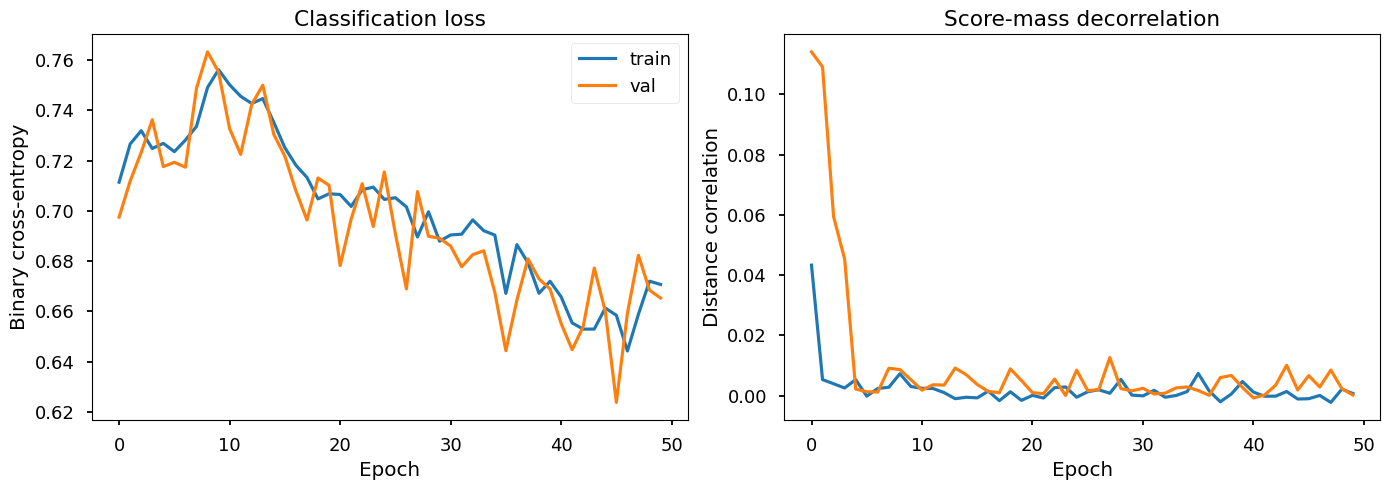

In [8]:

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(history_df["epoch"], history_df["train_loss_cls"], label="train")
ax[0].plot(history_df["epoch"], history_df["val_loss_cls"], label="val")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Binary cross-entropy")
ax[0].set_title("Classification loss")
ax[0].legend()

if "train_dCorr_s_m" in history_df and "val_dCorr_s_m" in history_df:
    ax[1].plot(history_df["epoch"], history_df["train_dCorr_s_m"], label="train")
    ax[1].plot(history_df["epoch"], history_df["val_dCorr_s_m"], label="val")
    ax[1].set_ylabel("Distance correlation")
else:
    ax[1].plot(history_df["epoch"], history_df["train_loss_cls"], color="tab:gray")
    ax[1].set_ylabel("Placeholder (enable LAMBDA_MASS to view decorrelation)")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Score-mass decorrelation")
plt.tight_layout()
plt.show()



## 6. Evaluation (`evaluation.py` lines 1-70)

We reproduce the single-score diagnostics: ROC curves, background mass sculpting, and the Jensen-Shannon divergence versus background rejection figure of merit used in the paper.


Test AUC = 0.621
Background distance-correlation(score, mass) = 0.0010
JSDvsR 10 0.1
JSDvsR 30 0.3
JSDvsR 50 0.5


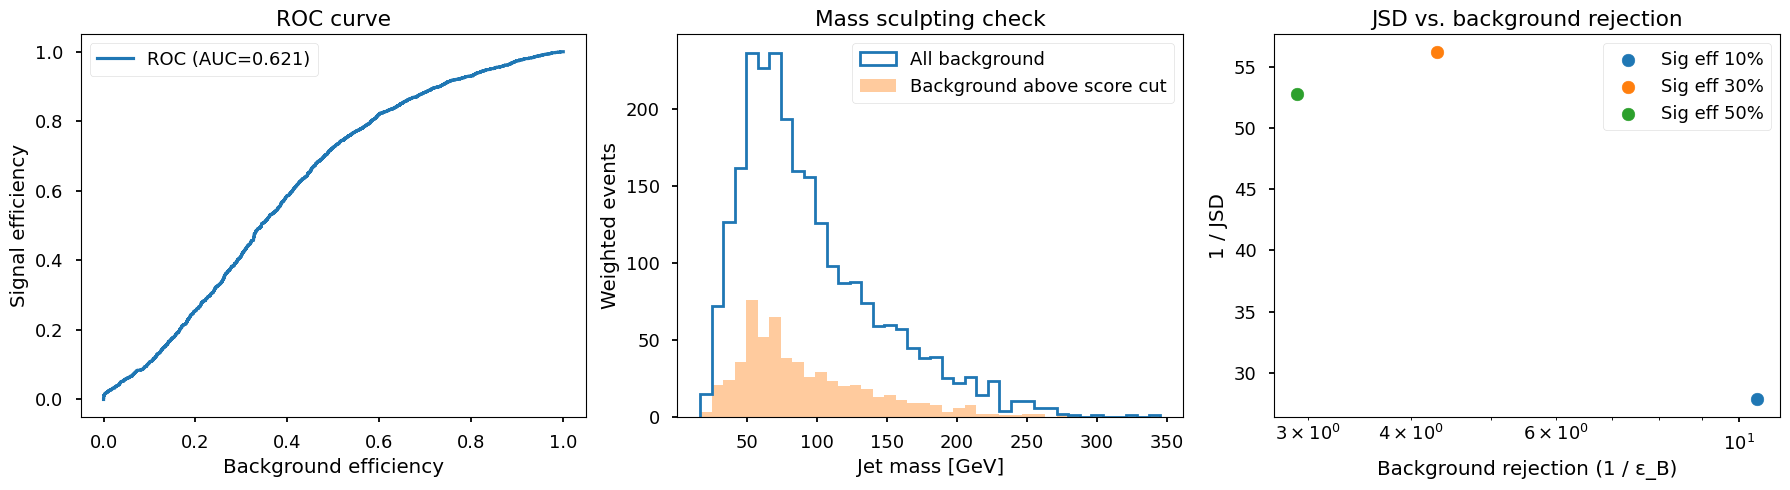

In [9]:
from importlib import reload
import evaluation
reload(evaluation)
from evaluation import JSDvsR

s_test, y_test, w_test, m_test, test_metrics = evaluate(model, test_loader)

fpr, tpr, _ = roc_curve(y_test, s_test, sample_weight=w_test)
roc_auc = auc(fpr, tpr)

# Background-only correlation for reporting
background = y_test < 0.5
if background.any():
    d_test = distance_corr_safe(
        torch.as_tensor(s_test[background]),
        torch.as_tensor(m_test[background]),
        torch.ones_like(torch.as_tensor(m_test[background])),
    ).item()
else:
    d_test = float("nan")

print(f"Test AUC = {roc_auc:.3f}")
print(f"Background distance-correlation(score, mass) = {d_test:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
axes[0].set_xlabel("Background efficiency")
axes[0].set_ylabel("Signal efficiency")
axes[0].set_title("ROC curve")
axes[0].legend()

nbins = 40
mass_range = (m_test.min(), m_test.max())
axes[1].hist(
    m_test[background], bins=nbins, range=mass_range, weights=w_test[background],
    histtype="step", label="All background", linewidth=2
)
cut = np.quantile(s_test[y_test > 0.5], 0.7)  # 30% background efficiency target
sel = background & (s_test > cut)
axes[1].hist(
    m_test[sel], bins=nbins, range=mass_range, weights=w_test[sel],
    histtype="stepfilled", alpha=0.4, label="Background above score cut"
)
axes[1].set_xlabel("Jet mass [GeV]")
axes[1].set_ylabel("Weighted events")
axes[1].set_title("Mass sculpting check")
axes[1].legend()

points = []
for sigeff in (10, 30, 50):
    rej, inv_jsd = JSDvsR(
        sigscore=s_test[y_test > 0.5],
        bgscore=s_test[background],
        bgmass=m_test[background],
        sigweights=w_test[y_test > 0.5],
        bgweights=w_test[background],
        sigeff=sigeff,
        nbins=nbins,
        minmass=mass_range[0],
        maxmass=mass_range[1],
    )
    points.append((rej, inv_jsd, sigeff))

for rej, inv_jsd, eff in points:
    axes[2].scatter(rej, inv_jsd, label=f"Sig eff {eff}%")
axes[2].set_xlabel("Background rejection (1 / ε_B)")
axes[2].set_ylabel("1 / JSD")
axes[2].set_title("JSD vs. background rejection")
axes[2].legend()
axes[2].set_xscale("log")

plt.tight_layout()
plt.show()



## 7. Persist artefacts

Save inference scores and the trained model weights for downstream ABCDisCo or `pyhf` studies.


In [10]:

results_df = pd.DataFrame({
    "score": s_test,
    "label": y_test,
    "weight": w_test,
    "mass": m_test,
})

results_path = Path("DNN_smallSample_abcdisco_single_disco_scores.parquet")
weights_path = Path("DNN_smallSample_abcdisco_single_disco_model.pt")

results_df.to_parquet(results_path, index=False)
torch.save(model.state_dict(), weights_path)

results_path, weights_path


(PosixPath('DNN_smallSample_abcdisco_single_disco_scores.parquet'),
 PosixPath('DNN_smallSample_abcdisco_single_disco_model.pt'))


## 8. Extending to Double-DisCo & QML studies

- **Recovering the paper-level numbers**: set `FULL_DATASET = True`, increase `EPOCHS` to 200, and sweep `LAMBDA_MASS` in the range 50-400 as in the reference scans.
- **Quantum experiments**: switch `BACKEND = "qml"`, tune `N_QUBITS`/`QML_LAYERS`, and initialise the PennyLane device with `qml.seed(SEED)` for reproducibility.
- **Transition to Double-DisCo**: after validating this notebook, open `ABCDisCo_tutorial.ipynb` for the two-network variant and reuse the saved preprocessing steps to initialise the dual heads.
